In [1]:
import sys
import scanpy as sc
import os
sys.path.append(os.path.abspath("FRLC"))
import FRLC
import FRLC_multimarginal
import importlib
import HiddenMarkovOT
import util_LR
from util_LR import convert_adata
import matplotlib.pyplot as plt

idxs = [1, 2, 3, 4]


In [2]:

timepoints_across_datasets = []
replicates_across_datasets = []

for i in idxs:
    
    filehandle_ME = f'/scratch/gpfs/ph3641/hm_ot/adata_JAX_dataset_{i}.h5ad'
    
    sys.path.insert(0, filehandle_ME)
    adata = sc.read_h5ad(filehandle_ME, backed="r")
    
    # Extract unique timepoints
    timepoints = list( adata.obs['day'].unique() )
    
    if 'P0' in timepoints:
        # Not one of the E_XYZ formatted stages, so removing
        timepoints.remove('P0')
    
    # Sort timepoints by the numeric value after removing the "E" prefix
    timepoints = sorted(timepoints, key=lambda tp: float(tp.replace("E", "")))
    
    # Extract unique replicates
    replicates = adata.obs['embryo_id'].unique()  # Biological replicates
    batches = adata.obs['experimental_batch'].unique()  # Technical batches
    
    replicates = []
    
    for tp in timepoints:
        replicates.append( adata[adata.obs['day'] == tp].obs['embryo_id'].unique()[0] )

    # Display results
    print("Timepoints:", timepoints)
    print("Biological Replicates (Embryo IDs):", replicates)
    print("Technical Batches:", batches)
    
    timepoints_across_datasets.append(timepoints)
    replicates_across_datasets.append(replicates)
    
    del adata

Timepoints: ['E8.5', 'E8.75', 'E9.0', 'E9.25', 'E9.5', 'E9.75', 'E10.0', 'E10.25', 'E10.5', 'E10.75']
Biological Replicates (Embryo IDs): ['embryo_11', 'embryo_14', 'embryo_16', 'embryo_20', 'embryo_24', 'embryo_28', 'embryo_30', 'embryo_33', 'embryo_34', 'embryo_35']
Technical Batches: ['run_4', 'run_15', 'run_17', 'run_19']
Categories (4, object): ['run_4', 'run_15', 'run_17', 'run_19']
Timepoints: ['E11.0', 'E11.25', 'E11.5', 'E11.75', 'E12.0', 'E12.25', 'E12.5', 'E12.75', 'E13.0', 'E13.25', 'E13.5', 'E13.75']
Biological Replicates (Embryo IDs): ['embryo_36', 'embryo_37', 'embryo_38', 'embryo_39', 'embryo_40', 'embryo_41', 'embryo_42', 'embryo_43', 'embryo_45', 'embryo_47', 'embryo_49', 'embryo_52']
Technical Batches: ['run_16', 'run_14', 'run_19', 'run_13']
Categories (4, object): ['run_13', 'run_14', 'run_16', 'run_19']
Timepoints: ['E14.0', 'E14.25', 'E14.333', 'E14.75', 'E15.0', 'E15.25', 'E15.5', 'E15.75', 'E16.0', 'E16.25', 'E16.5', 'E16.75']
Biological Replicates (Embryo IDs)

In [3]:
# Timepoints
print(timepoints_across_datasets)

# Replicated matched to each time
print(replicates_across_datasets)

[['E8.5', 'E8.75', 'E9.0', 'E9.25', 'E9.5', 'E9.75', 'E10.0', 'E10.25', 'E10.5', 'E10.75'], ['E11.0', 'E11.25', 'E11.5', 'E11.75', 'E12.0', 'E12.25', 'E12.5', 'E12.75', 'E13.0', 'E13.25', 'E13.5', 'E13.75'], ['E14.0', 'E14.25', 'E14.333', 'E14.75', 'E15.0', 'E15.25', 'E15.5', 'E15.75', 'E16.0', 'E16.25', 'E16.5', 'E16.75'], ['E17.0', 'E17.25', 'E17.5', 'E17.75', 'E18.0', 'E18.25', 'E18.5', 'E18.75']]
[['embryo_11', 'embryo_14', 'embryo_16', 'embryo_20', 'embryo_24', 'embryo_28', 'embryo_30', 'embryo_33', 'embryo_34', 'embryo_35'], ['embryo_36', 'embryo_37', 'embryo_38', 'embryo_39', 'embryo_40', 'embryo_41', 'embryo_42', 'embryo_43', 'embryo_45', 'embryo_47', 'embryo_49', 'embryo_52'], ['embryo_53', 'embryo_54', 'embryo_55', 'embryo_56', 'embryo_57', 'embryo_58', 'embryo_59', 'embryo_60', 'embryo_61', 'embryo_62', 'embryo_63', 'embryo_64'], ['embryo_65', 'embryo_66', 'embryo_67', 'embryo_68', 'embryo_69', 'embryo_70', 'embryo_71', 'embryo_72']]


In [4]:
"""
Timepoints, indexed by AnnData index
"""
timepoints_across_datasets =  [['E8.5', 'E8.75', 'E9.0', 'E9.25', 'E9.5', 'E9.75', 'E10.0', 'E10.25', 'E10.5', 'E10.75'], \
                               ['E11.0', 'E11.25', 'E11.5', 'E11.75', 'E12.0', 'E12.25', 'E12.5', 'E12.75', 'E13.0', 'E13.25', 'E13.5', 'E13.75'], \
                               ['E14.0', 'E14.25', 'E14.333', 'E14.75', 'E15.0', 'E15.25', 'E15.5', 'E15.75', 'E16.0', 'E16.25', 'E16.5', 'E16.75'], \
                               ['E17.0', 'E17.25', 'E17.5', 'E17.75', 'E18.0', 'E18.25', 'E18.5', 'E18.75']]

"""
For simplicity, we choose the first replicate for each timepoint as our dataset.
"""
replicates_across_datasets = [['embryo_11', 'embryo_14', 'embryo_16', 'embryo_20', 'embryo_24', 'embryo_28', 'embryo_30', 'embryo_33', 'embryo_34', 'embryo_35'], \
                              ['embryo_36', 'embryo_37', 'embryo_38', 'embryo_39', 'embryo_40', 'embryo_41', 'embryo_42', 'embryo_43', 'embryo_45', 'embryo_47', 'embryo_49', 'embryo_52'], \
                              ['embryo_53', 'embryo_54', 'embryo_55', 'embryo_56', 'embryo_57', 'embryo_58', 'embryo_59', 'embryo_60', 'embryo_61', 'embryo_62', 'embryo_63', 'embryo_64'], \
                              ['embryo_65', 'embryo_66', 'embryo_67', 'embryo_68', 'embryo_69', 'embryo_70', 'embryo_71', 'embryo_72']]


In [5]:
import pandas as pd
import clustering
import plotting
import pickle
import numpy as np


# Filehandle for final differentiation map outputs
diffmap_dir = "/scratch/gpfs/ph3641/hm_ot/ME_supervised_diffmap_moscot_allrep/"
#"/scratch/gpfs/ph3641/hm_ot/ME_supervised_diffmap_moscot/"
os.makedirs(diffmap_dir, exist_ok=True)

# Cell-type labels for all timepoints + replicates
df_cell = pd.read_csv("/scratch/gpfs/ph3641/hm_ot/df_cell.csv")
df_cell = df_cell.set_index("cell_id")


loading E8.5 to E8.75
loading E8.75 to E9.0
loading E9.0 to E9.25
loading E9.25 to E9.5


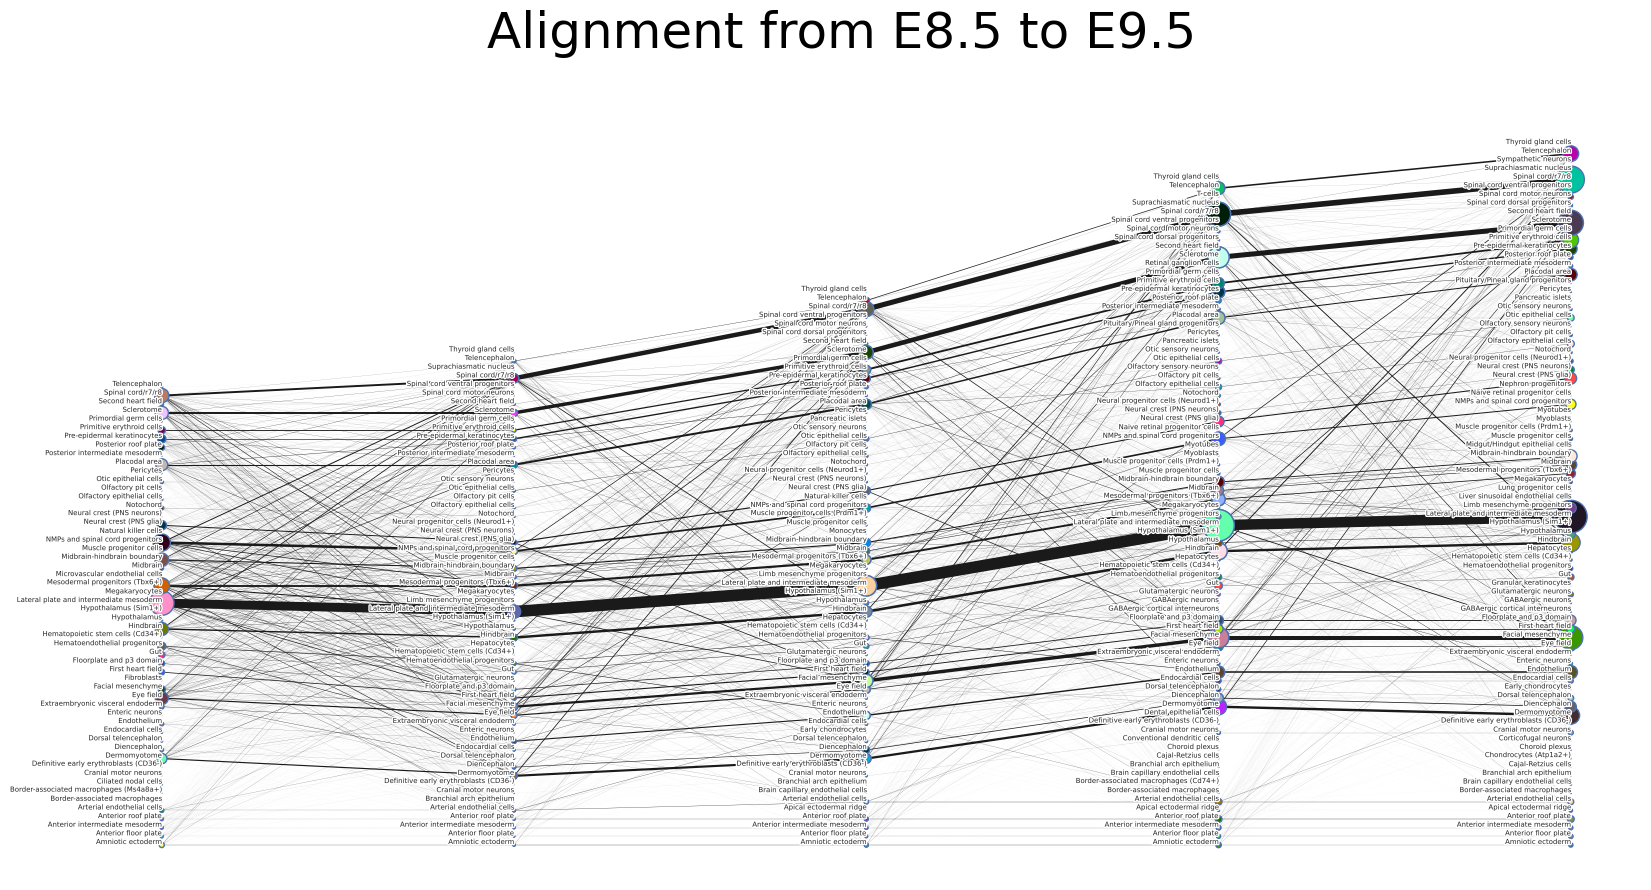

In [6]:
import os
import numpy as np
import pickle
import importlib
import plotting 

importlib.reload(plotting)

"""
timepoints = ['E8.5', 'E8.75', 'E9.0', 'E9.25', 'E9.5', 'E9.75', 'E10.0', 'E10.25', 'E10.5', 'E10.75',
              'E11.0', 'E11.25', 'E11.5', 'E11.75', 'E12.0', 'E12.25', 'E12.5', 'E12.75',
             'E13.0', 'E13.25', 'E13.5', 'E13.75', 'E14.0']
"""
timepoints = ['E8.5', 'E8.75', 'E9.0', 'E9.25', 'E9.5'] #, 'E9.75', 'E10.0']

_Qs = []
_Ts = []
_labels = []

for i in range(len(timepoints) - 1):
    
    t1 = timepoints[i]
    t2 = timepoints[i + 1]
    
    print(f'loading {t1} to {t2}')
    
    # Load Q and T matrices
    Q1 = np.load(os.path.join(diffmap_dir, f"{t1}_Q.npy"))
    Q2 = np.load(os.path.join(diffmap_dir, f"{t2}_Q.npy"))
    T12 = np.load(os.path.join(diffmap_dir, f"{t1}_{t2}_T.npy"))
    
    if i == 0:
        _Qs.append(Q1)
    _Qs.append(Q2)
    _Ts.append(T12)
    
    # Load labels
    with open(os.path.join(diffmap_dir, f"{t1}_types.pkl"), 'rb') as f:
        Label_t1 = pickle.load(f)
    with open(os.path.join(diffmap_dir, f"{t2}_types.pkl"), 'rb') as f:
        Label_t2 = pickle.load(f)
    
    if i == 0:
        _labels.append(Label_t1)
    _labels.append(Label_t2)

# Plot the full alignment
plotting.diffmap_from_QT(
    _Qs, _Ts, _labels,
    dsf=0.01,
    fontsize=5,
    linethick_factor=55,
    title=f"Alignment from {timepoints[0]} to {timepoints[-1]}",
    save_name=os.path.join("/scratch/gpfs/ph3641/hm_ot/ME_supervised_figs/all.png")
)

In [10]:
import differentiation_map_validation as dmv

edge_dir = "/scratch/gpfs/ph3641/hm_ot/edges.txt"
node_dir = "/scratch/gpfs/ph3641/hm_ot/nodes.txt"
# Load the data
nodes_df = pd.read_csv(node_dir, sep="\t")
edges_df = pd.read_csv(edge_dir, sep="\t")


G, labels_G = dmv.yield_differentiation_graph(nodes_df, edges_df, plotting=False)
edge_scores, diagonal_edge_scores = dmv.score_from_graph(_Qs, _Ts, _labels, timepoints,
                             G, labels_G, edges_df, 
                            )

npmis = []
diagonal_npmis = []

for key in edge_scores:
    # Assume at least one timepoint has transition, so apply max
    npmi_max = np.max(edge_scores[key])
    npmis.append(npmi_max)

for key in diagonal_edge_scores:
    diagonal_npmi_mean = np.mean(diagonal_edge_scores[key])
    diagonal_npmis.append(diagonal_npmi_mean)

plt.hist(npmis, bins=20)
plt.show()

plt.hist(diagonal_npmis, bins=20)
plt.show()

print(f'Mean NPMI (off-diagonal): {np.mean(npmis)}')
print(f'Mean NPMI (diagonal): {np.mean(diagonal_npmis)}')


KeyboardInterrupt



Mapping Amniotic ectoderm to self at times E8.5 to E9.0
Mapping Anterior floor plate to self at times E8.5 to E9.0
Mapping Anterior intermediate mesoderm to self at times E8.5 to E9.0
Mapping Anterior roof plate to self at times E8.5 to E9.0
Mapping Arterial endothelial cells to self at times E8.5 to E9.0
Mapping Cranial motor neurons to self at times E8.5 to E9.0
Mapping Definitive early erythroblasts (CD36-) to self at times E8.5 to E9.0
Mapping Dermomyotome to self at times E8.5 to E9.0
Mapping Diencephalon to self at times E8.5 to E9.0
Mapping Dorsal telencephalon to self at times E8.5 to E9.0
Mapping Endocardial cells to self at times E8.5 to E9.0
Mapping Endothelium to self at times E8.5 to E9.0
Mapping Enteric neurons to self at times E8.5 to E9.0
Mapping Extraembryonic visceral endoderm to self at times E8.5 to E9.0
Mapping Eye field to self at times E8.5 to E9.0
Mapping Facial mesenchyme to self at times E8.5 to E9.0
Mapping First heart field to self at times E8.5 to E9.0
Mapp

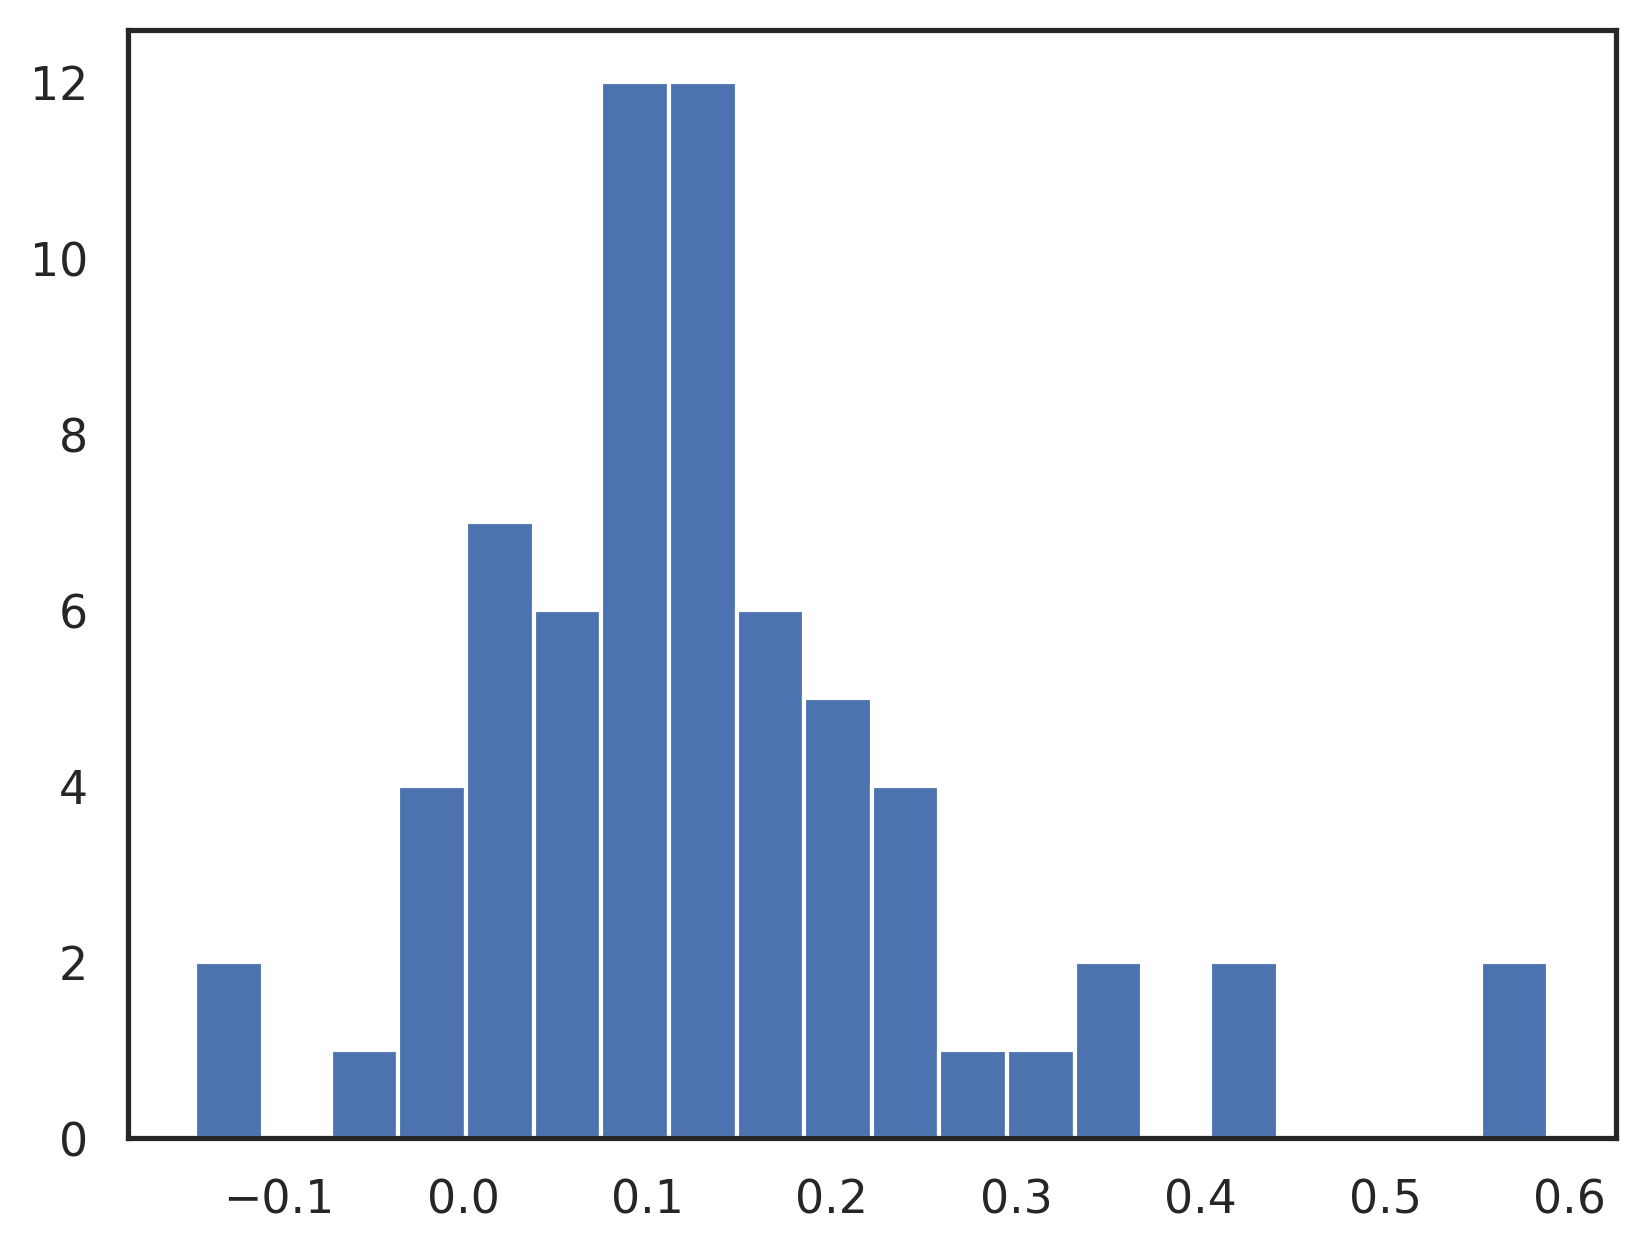

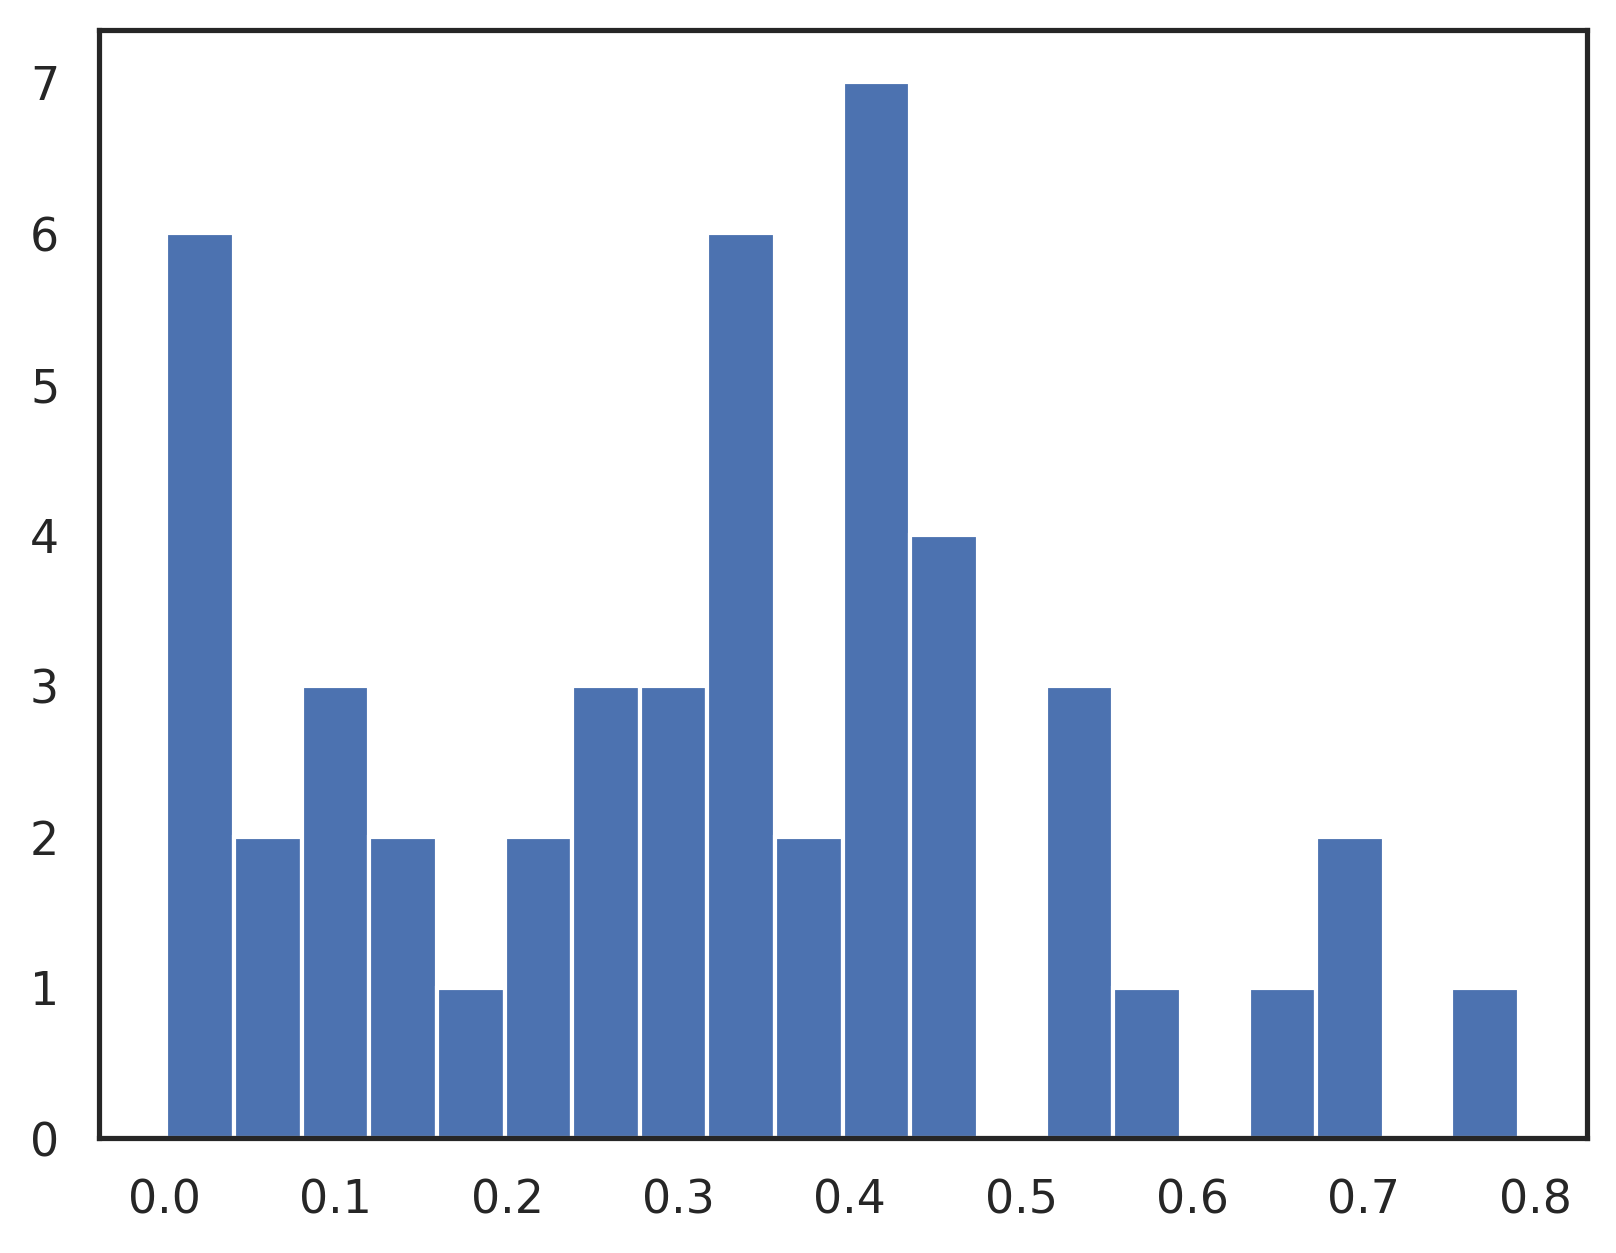

Median NPMI (off-diagonal): 0.11479516615636219
Median NPMI (diagonal): 0.32857014462713735
Mean NPMI (off-diagonal): 0.13269280182414814
Mean NPMI (diagonal): 0.31570847437185023


In [14]:
import matplotlib.pyplot as plt

T13 = _Ts[0] @ np.diag( 1/ np.sum(_Qs[1], axis=0) ) @ _Ts[1]
edge_scores, diagonal_edge_scores = dmv.score_from_graph([_Qs[0], _Qs[2]], [T13], [_labels[0], _labels[2]], ['E8.5', 'E9.0'],
                             G, labels_G, edges_df, 
                            )

npmis = []
diagonal_npmis = []

for key in edge_scores:
    # Assume at least one timepoint has transition, so apply max
    npmi_max = np.max(edge_scores[key])
    npmis.append(npmi_max)

for key in diagonal_edge_scores:
    diagonal_npmi_mean = np.mean(diagonal_edge_scores[key])
    diagonal_npmis.append(diagonal_npmi_mean)

plt.hist(npmis, bins=20)
plt.show()

plt.hist(diagonal_npmis, bins=20)
plt.show()

print(f'Median NPMI (off-diagonal): {np.median(npmis)}')
print(f'Median NPMI (diagonal): {np.median(diagonal_npmis)}')
print(f'Mean NPMI (off-diagonal): {np.mean(npmis)}')
print(f'Mean NPMI (diagonal): {np.mean(diagonal_npmis)}')

In [15]:

with open('edge_scores_moscot_3.pkl', 'wb') as f:
    pickle.dump(edge_scores, f)

with open('diagonal_edge_scores_moscot_3.pkl', 'wb') as f:
    pickle.dump(diagonal_edge_scores, f)


In [11]:
from collections import defaultdict


def NPMI(Tij, gi, gj, eps=1e-12):
    
    # Add epsilon to avoid division by zero or log(0)
    Tij_safe = max(Tij, eps)
    gi_safe = max(gi, eps)
    gj_safe = max(gj, eps)

    print(f'Tij: {Tij}, gi: {gi}, gj: {gj}')
    
    pmi = np.log2(Tij_safe / (gi_safe * gj_safe))
    npmi_val = pmi / (-np.log2(Tij_safe))
    
    return npmi_val


edge_scores = {}

for _, row in edges_df.iterrows():
    
    if row["x"] in G.nodes and row["y"] in G.nodes:
        
        type_1 = labels[row["x"]]
        type_2 = labels[row["y"]]
        
        print(f'Mapping {type_1} to {type_2}')
        
        for i in range(len(timepoints) - 1):
            
            t1 = timepoints[i]
            t2 = timepoints[i + 1]
            
            print(f'{t1} to {t2}')
            if i == 0:
                Q1 = _Qs[0]
                Label1 = _labels[0]
            else:
                Q1 = Q2
                Label1 = Label2
            
            Q2 = _Qs[i+1]
            Label2 = _labels[i+1]
            
            T12 = _Ts[i]
            
            g1 = np.sum(Q1, axis = 0)
            g2 = np.sum(Q2, axis = 0)
            
            if (type_1 in Label1 and type_2 in Label2) and (type_1 != type_2):
                
                print(f'Mapping {type_1} to {type_2} at times {t1} to {t2}')
                
                idx1, idx2 = Label1.index(type_1), Label2.index(type_2)
                i_max = np.argmax(T12[:, idx2])
                
                print(f'HM-OT proposed transition {Label1[i_max]} to {type_2}')
                
                score = NPMI(T12[idx1, idx2], \
                             g1[idx1], g2[idx2])

                if type_2 in Label1:
                    # If a diagonal-dominant transition
                    idx1, idx2 = Label1.index(type_2), Label2.index(type_2)
                    score_diag = NPMI(T12[idx1, idx2], \
                             g1[idx1], g2[idx2])
                    print(f'Score: {score}, Score Diag: {score_diag}')
                
                # Append score for transition for each timepoint
                key = (type_1, type_2)
                
                if key not in edge_scores:
                    edge_scores[key] = []
                edge_scores[key].append(score)


print(f'Assessing {len(edge_scores)} transitions from Qiu et al 2024')

npmis = []
for key in edge_scores:
    print(f'Transition: {key}')
    # Assume at least one timepoint has transition, so apply max
    npmi_max = np.max(edge_scores[key])
    npmis.append(npmi_max)
    print(f'max NPMI: {npmi_max}')
    
plt.hist(npmis, bins=20)
plt.show()

NameError: name 'labels' is not defined

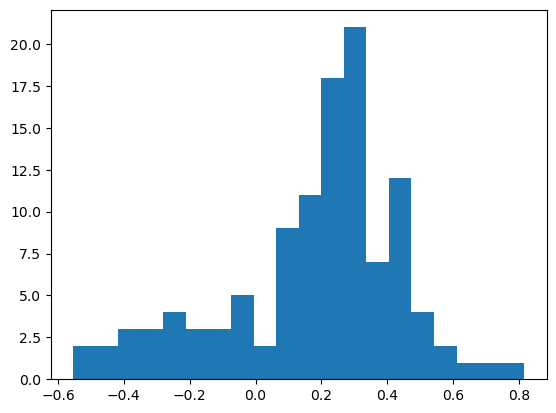

In [15]:
plt.hist(npmis, bins=20)
plt.show()

In [16]:
print(edge_scores)

{('Hematoendothelial progenitors', 'Endothelium'): [0.5220476275366541, 0.5545192879294626, 0.61189146874643, 0.5930788634356162, 0.4622313283932917, 0.3931786763596511, 0.5220476275366541, 0.5545192879294626, 0.61189146874643, 0.5930788634356162, 0.4622313283932917, 0.3931786763596511, 0.5220476275366541, 0.5545192879294626, 0.61189146874643, 0.5930788634356162, 0.4622313283932917, 0.3931786763596511], ('Hindbrain', 'Midbrain'): [0.02161440809535084, -0.014088798274719634, 0.0045520687746666, 0.18335606581895744, 0.101982801453052, 0.13435113423159745, 0.02161440809535084, -0.014088798274719634, 0.0045520687746666, 0.18335606581895744, 0.101982801453052, 0.13435113423159745], ('Hindbrain', 'Anterior roof plate'): [0.2892144536997365, 0.24411008216309382, 0.17625717363041907, 0.13928071342769657, 0.09780874384702774, 0.03007876045290413, 0.2892144536997365, 0.24411008216309382, 0.17625717363041907, 0.13928071342769657, 0.09780874384702774, 0.03007876045290413], ('Endothelium', 'Arteria

# Diagonal Only (below)

In [17]:
from collections import defaultdict

edge_scores_diagonal = {}

for node in G.nodes:
    type = labels[node]
    
    print(f'Mapping diagonal transition {type} to self at adjacent timepoint.')
    
    for i in range(len(timepoints) - 1):
        
        t1 = timepoints[i]
        t2 = timepoints[i + 1]
        
        print(f'loading {t1} to {t2}')
        if i == 0:
            Q1 = _Qs[0]
            Label1 = _labels[0]
        else:
            Q1 = Q2
            Label1 = Label2
        
        Q2 = _Qs[i+1]
        Label2 = _labels[i+1]
        
        T12 = _Ts[i]
        
        g1 = np.sum(Q1, axis = 0)
        g2 = np.sum(Q2, axis = 0)
        
        if type in Label1 and type in Label2:
            
            print(f'Mapping {type} to self at times {t1} to {t2}')
            idx1, idx2 = Label1.index(type), Label2.index(type)
            
            score = NPMI(T12[idx1, idx2], \
                         g1[idx1], g2[idx2])
            
            # Append score for transition for each timepoint
            key = type
            if key not in edge_scores_diagonal:
                edge_scores_diagonal[key] = []
            edge_scores_diagonal[key].append(score)




Mapping diagonal transition Oocyte to self at adjacent timepoint.
loading E8.5 to E8.75
loading E8.75 to E9.0
loading E9.0 to E9.25
loading E9.25 to E9.5
loading E9.5 to E9.75
loading E9.75 to E10.0
Mapping diagonal transition 1-cell to self at adjacent timepoint.
loading E8.5 to E8.75
loading E8.75 to E9.0
loading E9.0 to E9.25
loading E9.25 to E9.5
loading E9.5 to E9.75
loading E9.75 to E10.0
Mapping diagonal transition 2-cell to self at adjacent timepoint.
loading E8.5 to E8.75
loading E8.75 to E9.0
loading E9.0 to E9.25
loading E9.25 to E9.5
loading E9.5 to E9.75
loading E9.75 to E10.0
Mapping diagonal transition 4-cell to self at adjacent timepoint.
loading E8.5 to E8.75
loading E8.75 to E9.0
loading E9.0 to E9.25
loading E9.25 to E9.5
loading E9.5 to E9.75
loading E9.75 to E10.0
Mapping diagonal transition 8-cell to self at adjacent timepoint.
loading E8.5 to E8.75
loading E8.75 to E9.0
loading E9.0 to E9.25
loading E9.25 to E9.5
loading E9.5 to E9.75
loading E9.75 to E10.0
Mappi

Assessing 77 ground-truth transitions from Qiu et al 2024
Transition: Extraembryonic visceral endoderm
max NPMI: 0.977873254003387
Transition: Amniotic ectoderm
max NPMI: 0.8129166889271301
Transition: Endothelium
max NPMI: 0.904817810239619
Transition: Gut
max NPMI: 0.7684789267536676
Transition: Hematoendothelial progenitors
max NPMI: 0.6818120510319718
Transition: Hindbrain
max NPMI: 0.7045760196681886
Transition: Midbrain
max NPMI: 0.62694578482132
Transition: Notochord
max NPMI: 0.8929051516684728
Transition: Primitive erythroid cells
max NPMI: 0.9521111726213088
Transition: Primordial germ cells
max NPMI: 0.6515369657140703
Transition: Arterial endothelial cells
max NPMI: 0.8096582541417023
Transition: Pericytes
max NPMI: 0.3088887217766932
Transition: Brain capillary endothelial cells
max NPMI: 0.5842906854942423
Transition: Endocardial cells
max NPMI: 0.8209895274240395
Transition: Liver sinusoidal endothelial cells
max NPMI: -0.2283529723984562
Transition: Granular keratinocyt

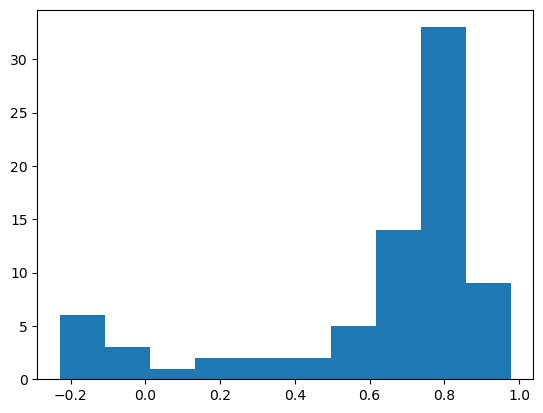

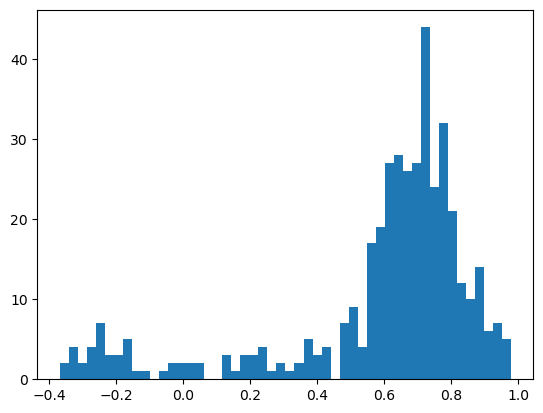

{'Extraembryonic visceral endoderm': [0.977873254003387, 0.6756631071901484, 0.7238304976837808, 0.977873254003387, 0.6756631071901484, 0.7238304976837808, 0.977873254003387, 0.6756631071901484, 0.7238304976837808], 'Amniotic ectoderm': [0.7471460753356908, 0.7694080309604765, 0.6874733135353084, 0.7552686375353669, 0.8129166889271301, 0.7196569280562501, 0.7471460753356908, 0.7694080309604765, 0.6874733135353084, 0.7552686375353669, 0.8129166889271301, 0.7196569280562501], 'Endothelium': [0.5026946652098173, 0.718717373106697, 0.749081394248853, 0.8719719380887678, 0.8823190917581095, 0.904817810239619, 0.5026946652098173, 0.718717373106697, 0.749081394248853, 0.8719719380887678, 0.8823190917581095, 0.904817810239619], 'Gut': [0.4269755207145968, 0.6620872779263199, 0.5677355489799214, 0.7116144944640933, 0.7684789267536676, 0.6886518819311356, 0.4269755207145968, 0.6620872779263199, 0.5677355489799214, 0.7116144944640933, 0.7684789267536676, 0.6886518819311356], 'Hematoendothelial pr

In [18]:
print(f'Assessing {len(edge_scores_diagonal)} ground-truth transitions from Qiu et al 2024')

npmis = []
npmis_all = []
for key in edge_scores_diagonal:
    
    print(f'Transition: {key}')
    npmi_max = np.max(edge_scores_diagonal[key])
    npmis.append(npmi_max)
    
    npmis_all.extend(edge_scores_diagonal[key])
    print(f'max NPMI: {npmi_max}')
    
plt.hist(npmis)
plt.show()

plt.hist(npmis_all, bins = 50)
plt.show()

print(edge_scores_diagonal)

Self-Transition: Extraembryonic visceral endoderm
max NPMI: 0.977873254003387
Self-Transition: Amniotic ectoderm
max NPMI: 0.8129166889271301
Self-Transition: Endothelium
max NPMI: 0.904817810239619
Self-Transition: Gut
max NPMI: 0.7684789267536676
Self-Transition: Hematoendothelial progenitors
max NPMI: 0.6818120510319718
Self-Transition: Hindbrain
max NPMI: 0.7045760196681886
Self-Transition: Midbrain
max NPMI: 0.62694578482132
Self-Transition: Notochord
max NPMI: 0.8929051516684728
Self-Transition: Primitive erythroid cells
max NPMI: 0.9521111726213088
Self-Transition: Primordial germ cells
max NPMI: 0.6515369657140703
Self-Transition: Arterial endothelial cells
max NPMI: 0.8096582541417023
Self-Transition: Pericytes
max NPMI: 0.3088887217766932
Self-Transition: Brain capillary endothelial cells
max NPMI: 0.5842906854942423
Self-Transition: Endocardial cells
max NPMI: 0.8209895274240395
Self-Transition: Liver sinusoidal endothelial cells
max NPMI: -0.2283529723984562
Self-Transition

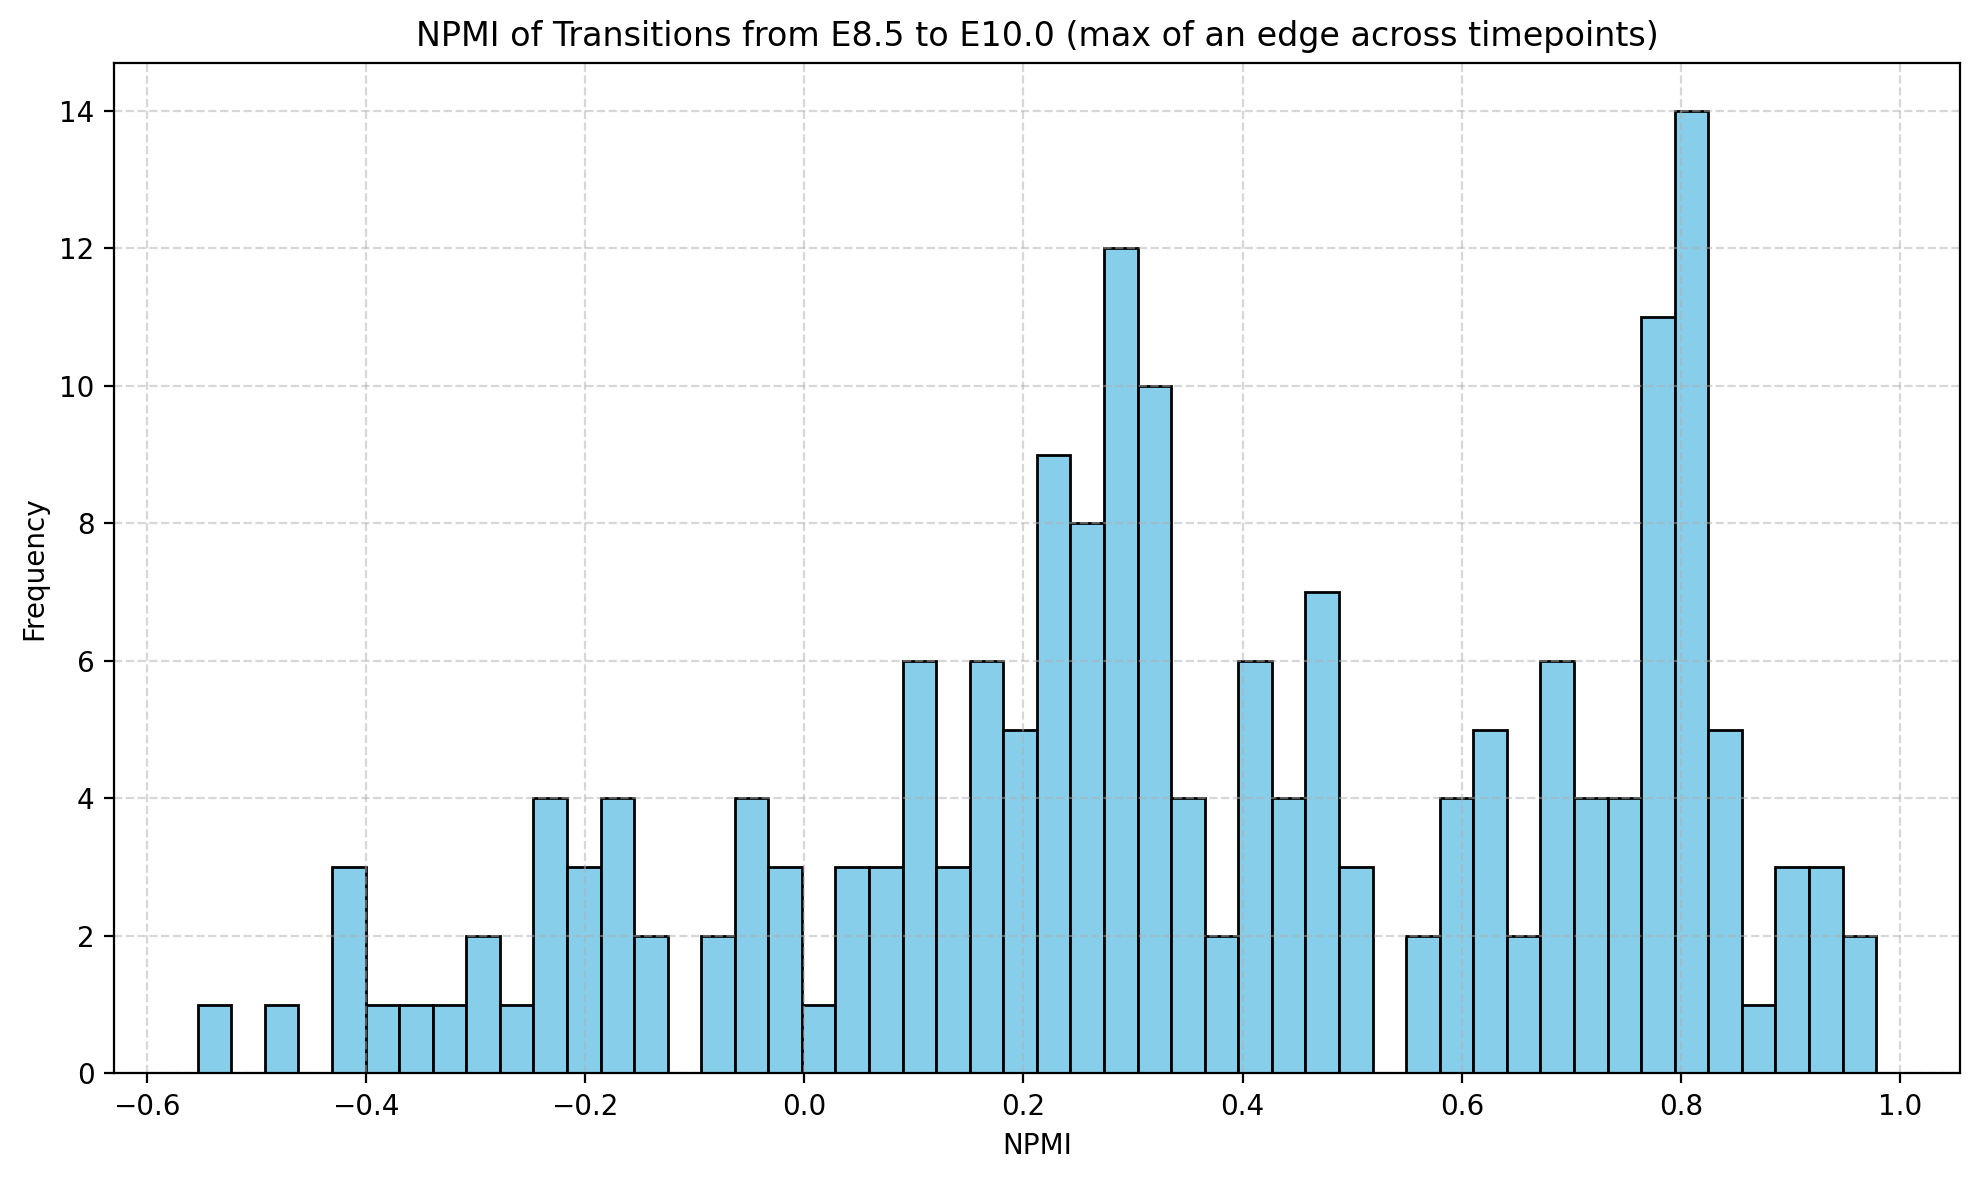

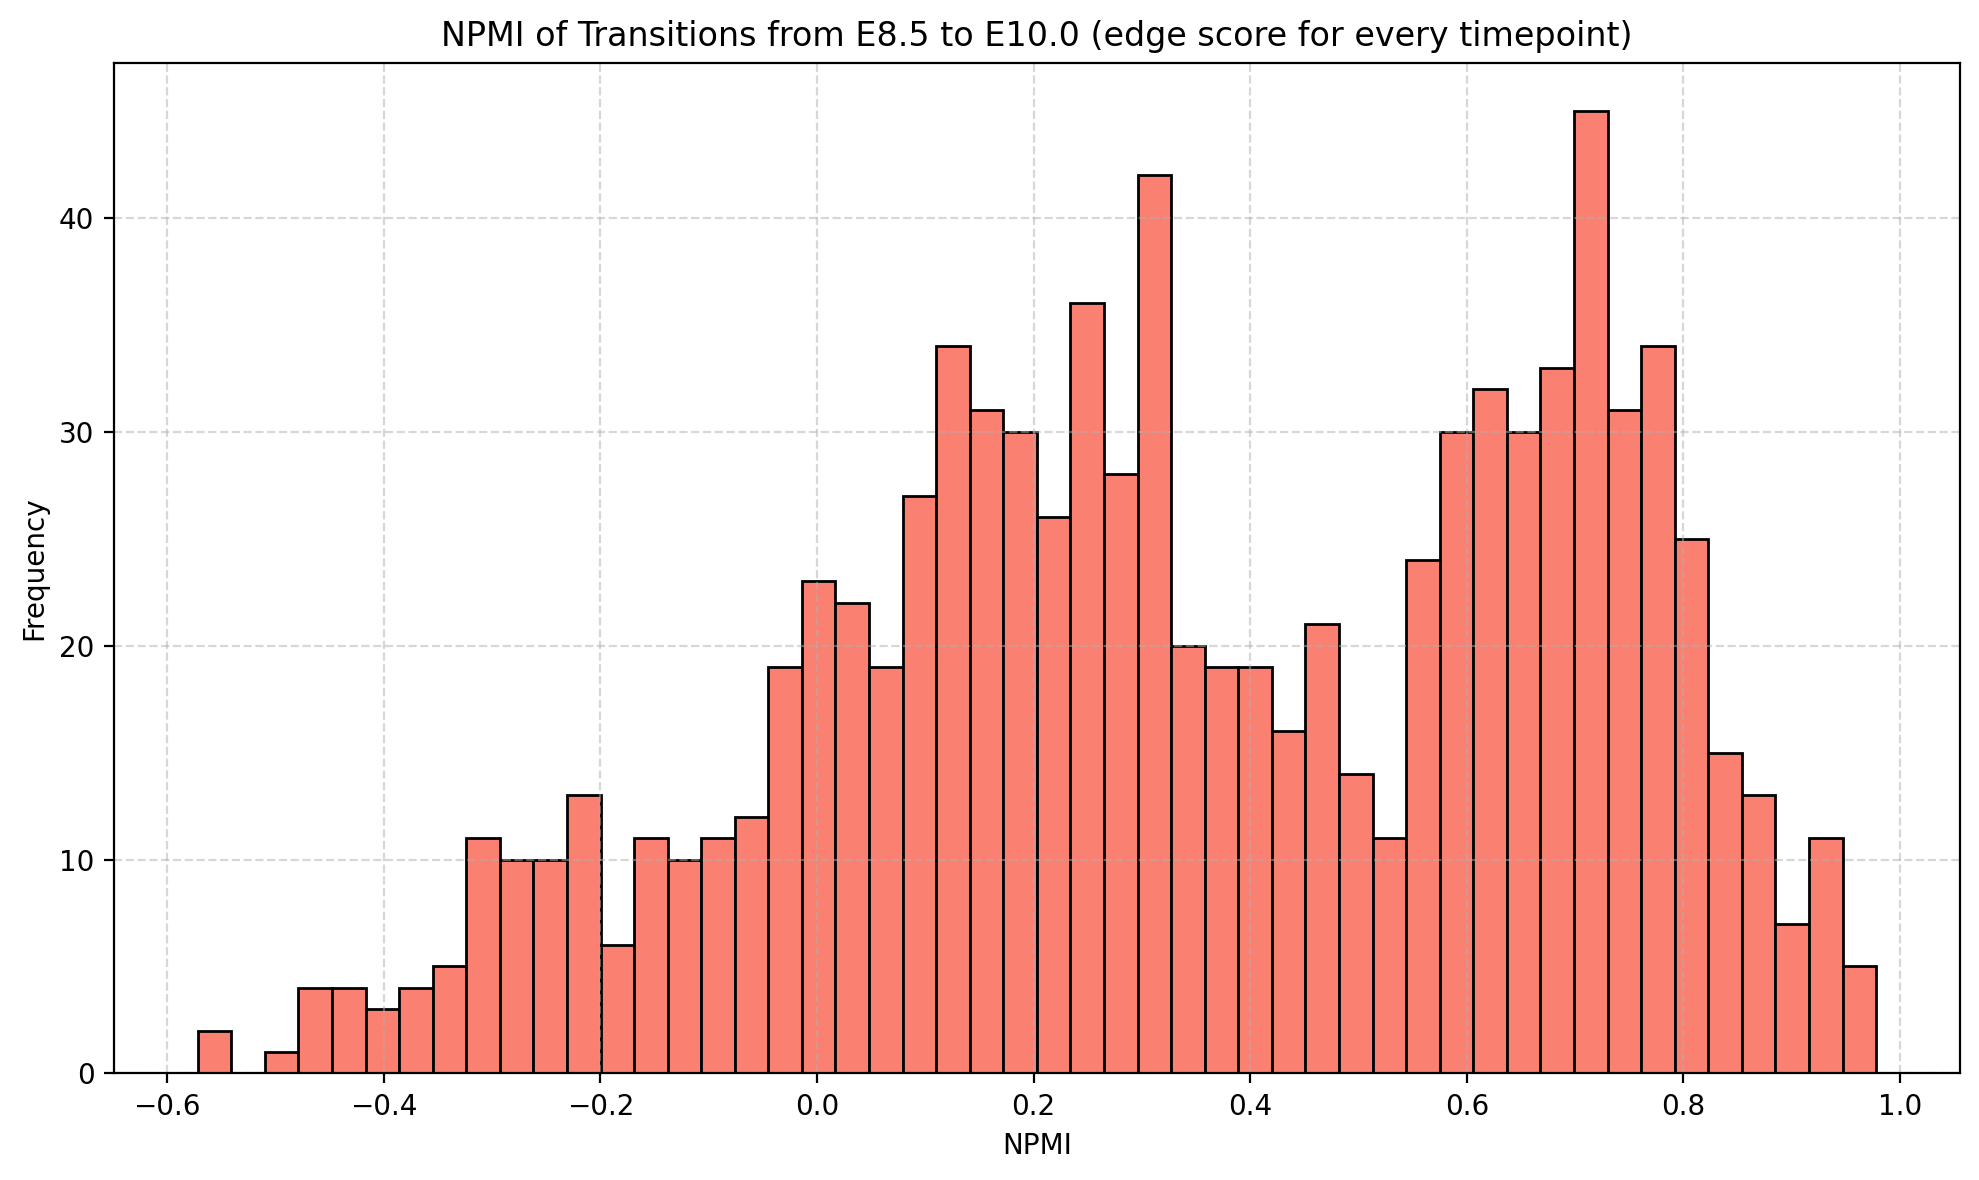

In [19]:


npmis = []
npmis_all = []

# Diagonal transitions
for key in edge_scores_diagonal:
    
    print(f'Self-Transition: {key}')
    npmi_max = np.max(edge_scores_diagonal[key])
    npmis.append(npmi_max)
    
    npmis_all.extend(edge_scores_diagonal[key])
    print(f'max NPMI: {npmi_max}')

# Off-diagonal transitions
for key in edge_scores:
    
    print(f'Transition: {key}')
    npmi_max = np.max(edge_scores[key])
    npmis.append(npmi_max)
    
    npmis_all.extend(edge_scores[key])
    print(f'max NPMI: {npmi_max}')


# Set a high DPI and figure size
plt.figure(figsize=(10, 6), dpi=200)
plt.title("NPMI of Transitions from " + timepoints[0] + " to " + timepoints[-1] + " (max of an edge across timepoints)")
plt.ylabel("Frequency")
plt.xlabel("NPMI")
plt.grid(True, linestyle='--', alpha=0.5)
plt.hist(npmis, bins=50, color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6), dpi=200)
plt.title("NPMI of Transitions from " + timepoints[0] + " to " + timepoints[-1]  + " (edge score for every timepoint)")
plt.ylabel("Frequency")
plt.xlabel("NPMI")
plt.grid(True, linestyle='--', alpha=0.5)
plt.hist(npmis_all, bins=50, color='salmon', edgecolor='black')
plt.tight_layout()
plt.show()


In [26]:
np.save('moscot_max_NPMI.npy',npmis)

In [ ]:
'''
import pandas as pd

xlsx = pd.ExcelFile("Qiu2024.xlsx")
df = pd.read_excel(xlsx, sheet_name='Table.21', header=2)
df_subset = df[["x_name", "y_name", "MNN_pairs_normalized"]]

df_subset

edge_scores_MNN = { }

edge_scores_MNN_2 = { }


for _, row in df_subset.iterrows():
    
    if _ % 100 == 0:
        print(f'Edge {_}/{len(df_subset)}')
    
    # Edge (unfortunately, not time-indexed)
    type_1 = row['x_name']
    type_2 = row['y_name']
    
    # Compute NPMI type_1 -> type_2 for all timepoints
    for i in range(len(timepoints) - 1):
            
            t1 = timepoints[i]
            t2 = timepoints[i + 1]
            
            if i == 0:
                Q1 = _Qs[0]
                Label1 = _labels[0]
            else:
                Q1 = Q2
                Label1 = Label2
            
            Q2 = _Qs[i+1]
            Label2 = _labels[i+1]
            
            T12 = _Ts[i]
            
            g1 = np.sum(Q1, axis = 0)
            g2 = np.sum(Q2, axis = 0)
            
            if (type_1 in Label1 and type_2 in Label2):
                
                idx1, idx2 = Label1.index(type_1), Label2.index(type_2)
                i_max = np.argmax(T12[:, idx2])
                score = NPMI(T12[idx1, idx2], \
                             g1[idx1], g2[idx2])
                
                # Append score for transition for each timepoint
                key = (type_1, type_2)
                
                if key not in edge_scores_MNN:
                    edge_scores_MNN[key] = []
                    edge_scores_MNN_2[key] = float( row['MNN_pairs_normalized'] )
                    
                edge_scores_MNN[key].append(score)

                print(f'({type_1},{type_2}) NPMI: {score}, MNN score: {edge_scores_MNN_2[key]}')
        

xs = []
ys = []

for key in edge_scores_MNN:
    scores = edge_scores_MNN[key]
    max_score = max(scores)
    
    MNN_score = edge_scores_MNN_2[key]

    if max_score > 0:
        xs.append(np.log(MNN_score) )
        ys.append(max_score)

plt.scatter(xs, ys)
plt.show()
'''